In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, recall_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input

In [4]:
# Paths
train_dir = r'C:\Users\shrey\OneDrive\Desktop\AI Chatbot\New folder\Oral_Cancer\Dataset\Train'
val_dir = r'C:\Users\shrey\OneDrive\Desktop\AI Chatbot\New folder\Oral_Cancer\Dataset\Validation'
test_dir = r'C:\Users\shrey\OneDrive\Desktop\AI Chatbot\New folder\Oral_Cancer\Dataset\Test'

In [ ]:
# Image settings
image_size = (224, 224)  
batch_size = 32

In [6]:
# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

In [ ]:
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 782 images belonging to 2 classes.


In [9]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 171 images belonging to 2 classes.


In [10]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 175 images belonging to 2 classes.


In [11]:
# Compute class weights 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [12]:
# Build model: EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base


In [13]:
# After initial fit and before fine-tuning:
base_model.trainable = True
# Freeze only the first N layers (experiment N≈100)
for layer in base_model.layers[:100]:
    layer.trainable = False

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)


In [15]:
model = Model(inputs=base_model.input, outputs=output)

In [16]:
# Compile
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)



In [18]:
# Training
steps_per_epoch = max(1, len(train_generator))
validation_steps = max(1, len(val_generator))

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


c:\Users\shrey\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 2/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4219 - loss: 0.7736  

c:\Users\shrey\anaconda3\envs\tf-env\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6186 - loss: 0.6595 - val_accuracy: 0.5497 - val_loss: 0.7381 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 974ms/step - accuracy: 0.8125 - loss: 0.4804 - val_accuracy: 0.6199 - val_loss: 0.7286 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 973ms/step - accuracy: 0.8643 - loss: 0.3426 - val_accuracy: 0.7602 - val_loss: 0.5974 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 946ms/step - accuracy: 0.9034 - loss: 0.2727 - val_accuracy: 0.8187 - val_loss: 0.4141 - learning_rate: 1.0000e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 939ms/step - accuracy: 0.9491 - loss: 0.1741 - val_accuracy: 0.8830 - val_loss: 0.2146 - learning_rate: 1.0000e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 945ms/step - accuracy: 0.9365 - loss: 0.1834 - val_accuracy: 0.9298 - val_loss: 0.1791 - learning_rate: 1.0000e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9392 - l

In [19]:
# Fine-tuning 
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [20]:
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9958 - loss: 0.0202 - val_accuracy: 0.9942 - val_loss: 0.0365 - learning_rate: 1.0000e-05
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 913ms/step - accuracy: 0.9843 - loss: 0.0394 - val_accuracy: 0.9883 - val_loss: 0.0375 - learning_rate: 1.0000e-05
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 913ms/step - accuracy: 0.9858 - loss: 0.0481 - val_accuracy: 0.9883 - val_loss: 0.0382 - learning_rate: 1.0000e-05
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 906ms/step - accuracy: 0.9662 - loss: 0.0909 - val_accuracy: 0.9883 - val_loss: 0.0384 - learning_rate: 1.0000e-05
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 674ms/step - accuracy: 0.9925 - loss: 0.0365 - val_accuracy: 0.9883 - val_loss: 0.0382 - learning_rate: 1.0000e-05
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 674ms/step - accuracy: 0.9846 - loss: 0.0358 - val_accuracy: 0.9883 - val_loss: 0.0384 - learning_rate: 1.0000e-05
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 680ms/step - accura

In [22]:
# Save
model.save("oral_cancer_efficientnet_model.h5")

In [23]:
# Evaluate
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 0.9967 - loss: 0.0388
Test Accuracy: 0.9886


In [24]:
# Predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 559ms/step


In [25]:
def tta_predict(model, img, tta_steps=5):
    preds = []
    for _ in range(tta_steps):
        aug = train_datagen.random_transform(img)
        aug = np.expand_dims(aug, 0)
        preds.append(model.predict(aug)[0][0])
    return np.mean(preds)

# Run TTA predictions
tta_preds = []
for i in range(len(test_generator)):
    batch_x, _ = test_generator[i]
    for img in batch_x:
        tta_preds.append(tta_predict(model, img))

y_pred_prob = np.array(tta_preds)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

In [26]:
import tensorflow as tf

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        mod_factor = tf.keras.backend.pow((1 - p_t), gamma)
        return tf.keras.backend.mean(alpha_factor * mod_factor * bce)
    return loss

In [27]:
model.compile(
    optimizer=Adam(1e-5),          # lower LR for fine-tuning
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

In [28]:
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("AUC Score:", roc_auc_score(y_true, y_pred_prob))



Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        88
           1       1.00      0.98      0.99        87

    accuracy                           0.99       175
   macro avg       0.99      0.99      0.99       175
weighted avg       0.99      0.99      0.99       175

Confusion Matrix:
 [[88  0]
 [ 2 85]]
AUC Score: 0.9892894461859979


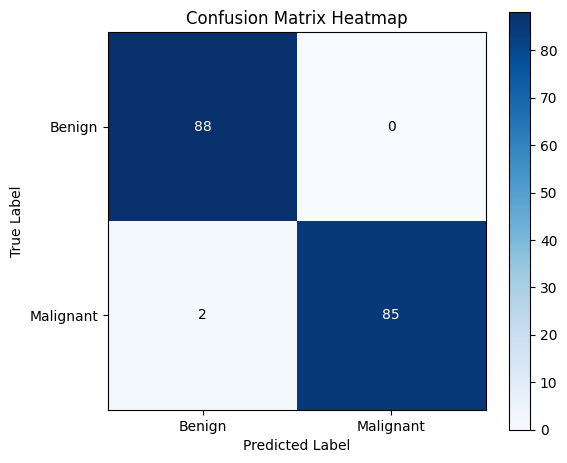

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
class_names = ['Benign', 'Malignant']  
# Plot heatmap
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Heatmap')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Annotate each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [29]:
best_thr, best_rec = 0.5, 0
for t in np.arange(0.2, 0.8, 0.05):
    preds = (y_pred_prob > t).astype(int)
    rec = recall_score(test_generator.classes, preds)
    if rec > best_rec:
        best_rec, best_thr = rec, t
print(f"\nBest recall {best_rec:.3f} at threshold {best_thr:.2f}")



Best recall 0.977 at threshold 0.20


In [37]:
print(train_generator.class_indices)


{'cancer': 0, 'non-cancer': 1}


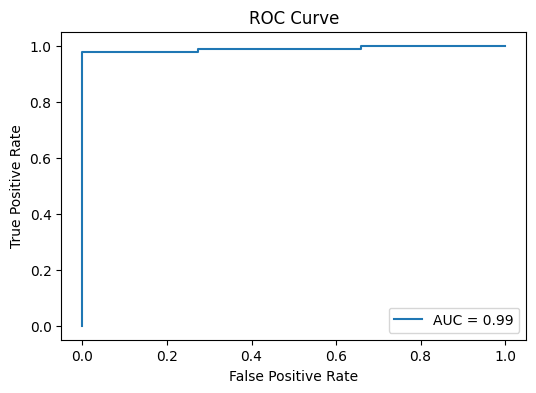

In [30]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_pred_prob):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [32]:
# Optional: Threshold tuning
print("\nRecall at different thresholds:")
for t in np.arange(0.3, 0.7, 0.05):
    preds = (y_pred_prob > t).astype("int32")
    recall = recall_score(y_true, preds)
    print(f"Threshold={t:.2f} => Recall: {recall:.3f}")


Recall at different thresholds:
Threshold=0.30 => Recall: 0.977
Threshold=0.35 => Recall: 0.977
Threshold=0.40 => Recall: 0.977
Threshold=0.45 => Recall: 0.977
Threshold=0.50 => Recall: 0.977
Threshold=0.55 => Recall: 0.977
Threshold=0.60 => Recall: 0.977
Threshold=0.65 => Recall: 0.977


In [34]:
import matplotlib.pyplot as plt

# Combine accuracy and loss values
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

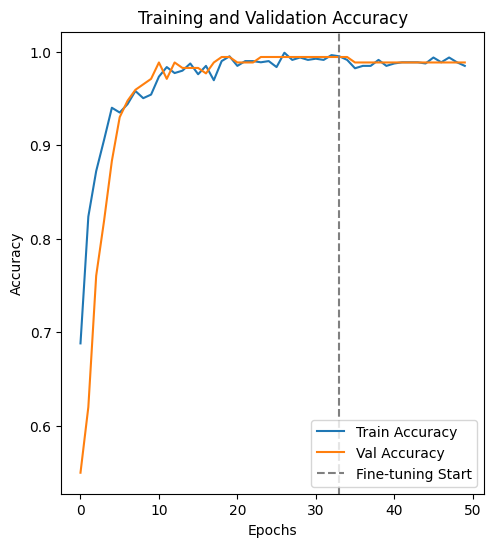

In [35]:
# Plot Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.axvline(x=len(history.history['accuracy']) - 1, color='gray', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

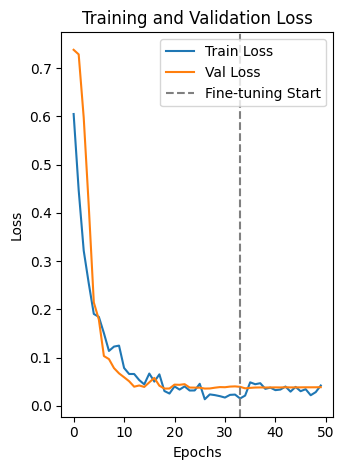

In [36]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.axvline(x=len(history.history['loss']) - 1, color='gray', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\shrey\anaconda3\envs\tf-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


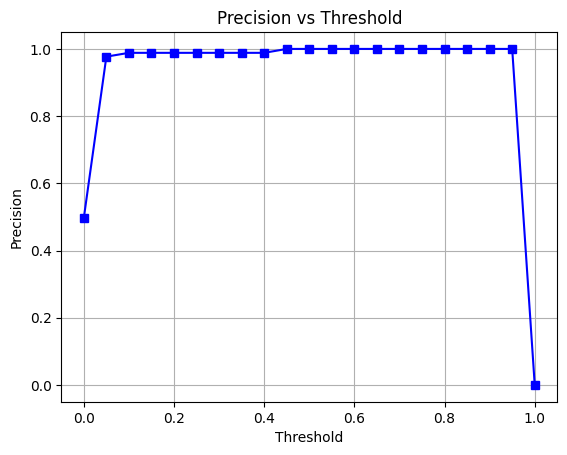

In [ ]:
#Precision_score Curve.
from sklearn.metrics import precision_score

precisions = [(precision_score(y_true, (y_pred_prob > t).astype(int))) for t in thresholds]

plt.figure()
plt.plot(thresholds, precisions, marker='s', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.show()


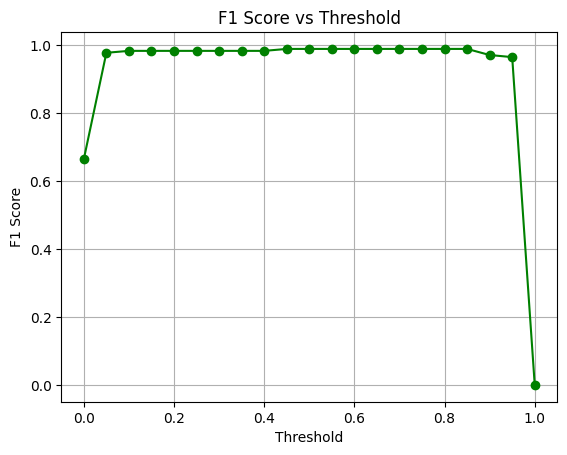

In [ ]:
#f1_score Curve.
from sklearn.metrics import f1_score
thresholds = np.arange(0.0, 1.01, 0.05)
f1_scores = [(f1_score(y_true, (y_pred_prob > t).astype(int))) for t in thresholds]

plt.figure()
plt.plot(thresholds, f1_scores, marker='o', color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()

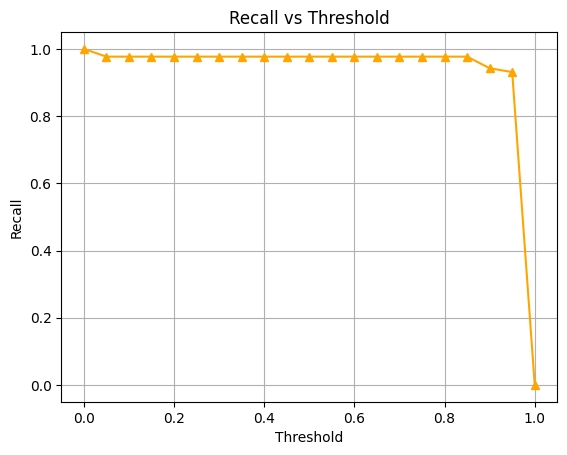

In [ ]:
#Recall_score Curve.
from sklearn.metrics import recall_score

recalls = [(recall_score(y_true, (y_pred_prob > t).astype(int))) for t in thresholds]

plt.figure()
plt.plot(thresholds, recalls, marker='^', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.show()